In [383]:
%load_ext autoreload
%autoreload 2

from nca.models import BaselineNCA, FCInvAE
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation
from copy import deepcopy

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML
from nca.utils import conv_same

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
def make_gif(nca_out, fps=10):
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize((500, 500), Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)

    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [235]:
device = "cuda"

In [236]:
sampled_nca = BaselineNCA(hidden_n=20, zero_w2=False).to(device)

In [402]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 10
        hid = 5

        self.kernel = nn.Sequential(
            conv_same(1, perc, ks=5, padding_mode="zeros"),
            nn.LeakyReLU(),
            nn.BatchNorm2d(perc),
            conv_same(perc, perc, ks=1, padding_mode="zeros"),
        )
        self.hid = nn.Sequential(
            conv_same(perc, hid, ks=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(hid),
        )
        self.rule = conv_same(hid, 1, ks=1, bias=False)
        self.lerp = conv_same(hid, 1, ks=1, bias=False)

        for p in self.kernel.parameters():
            nn.init.normal_(p, 1, 0)
        for p in list(self.rule.parameters()) + list(self.hid.parameters()) + list(self.lerp.parameters()):
            nn.init.uniform_(p, -1.2, 1.2)

    def forward_many(self, x, steps):
        seq = [x]
        for i in range(steps):
            perc = self.kernel(x)
            hid = self.hid(perc)
            y = torch.tanh(self.rule(hid))
            l = torch.sigmoid(self.lerp(hid))
            x = l * x + (1 - l) * y
            seq.append(x)
        seq = torch.stack(seq, axis=0)
        return seq

In [471]:
sampled_nca = SimpleNCA().to(device)

In [472]:
S, s = 64, 32
image_rep = torch.zeros(1, 1, S, S).to(device)
torch.nn.init.normal_(image_rep[:, :, S // 2 - s // 2:S // 2 + s // 2, S // 2 - s // 2:S // 2 + s // 2])
b, c, h, w = image_rep.shape

nca_out = sampled_nca.forward_many(image_rep, steps=60)

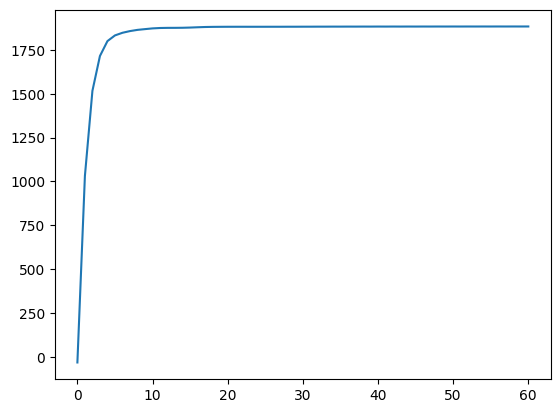

In [473]:
vs = nca_out.sum(axis=[-1, -2])[:, 0, 0].detach().cpu()
plt.plot(vs)

In [474]:
nca_out[0, :, 0].shape

torch.Size([1, 64, 64])


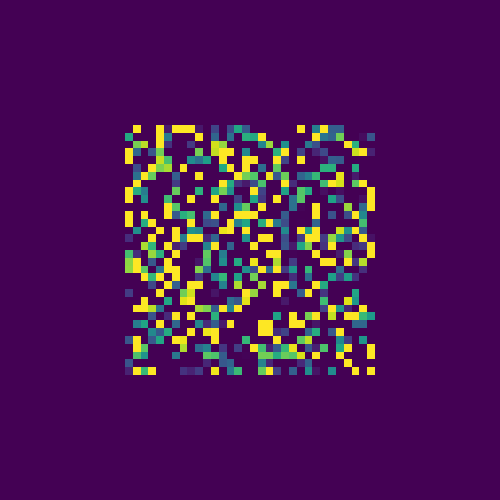

In [475]:
make_gif(nca_out[:, 0, 0], fps=10)

In [476]:
noise_size = 1
noiser = nn.Sequential(
    augmentation.RandomPerspective(0.6, p=0.5),
#     augmentation.RandomBoxBlur(kernel_size=(5, 5), p=noise_size),
    augmentation.RandomGaussianNoise(0, 1, same_on_batch=False, p=noise_size),
    augmentation.RandomErasing((0.1, 0.2), (0.3, 1 / 0.3), p=noise_size),
)

In [477]:
inp = Image.fromarray((np.arange(49).reshape(7,7) % 2 * 255).astype(np.uint8)).resize((200, 200), Image.NEAREST)

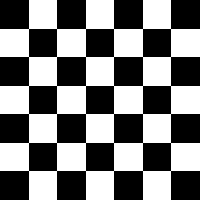

In [478]:
inp

In [479]:
np_inp = torch.tensor(np.array(inp)).to(float).unsqueeze(0).repeat(8, 1, 1) / 255
np_inp = np_inp.unsqueeze(1)
np_inp.shape

torch.Size([8, 1, 200, 200])

In [480]:
noised_out = noiser(np_inp)
noised_out.shape

torch.Size([8, 1, 200, 200])

In [481]:
import torchvision
grid_out = torchvision.utils.make_grid(noised_out).permute(1, 2, 0)
grid_out.shape

torch.Size([204, 1618, 3])

In [482]:
# Image.fromarray((grid_out.numpy() * 10).astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.343657731366426..5.633667059272764].


(-0.5, 1617.5, 203.5, -0.5)

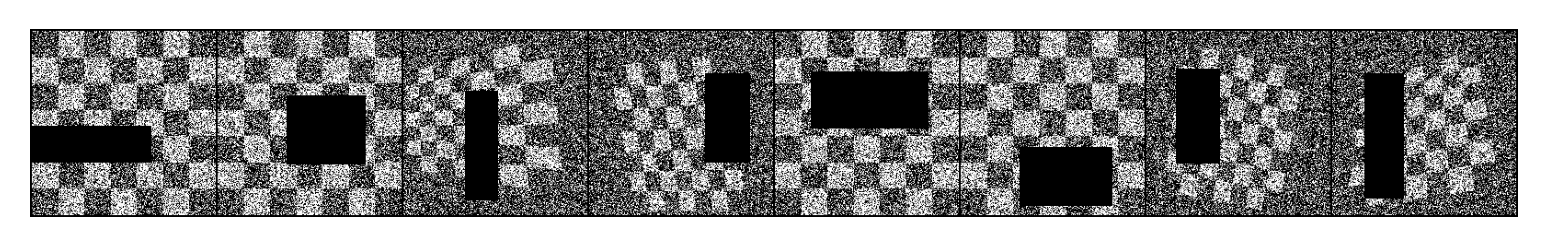

In [483]:
plt.subplots(dpi=300)
plt.imshow(grid_out)
plt.axis("off")

In [484]:
inv_ae = FCInvAE(msg_size=100, frame_size=16, decode_frame_size=128).to(device)
nca = deepcopy(sampled_nca)
lr = 0.0001
optim = torch.optim.Adam(list(nca.parameters()) + list(inv_ae.parameters()), lr=lr)
history = []

bs = 32
steps = 30
its = 1000

pbar = tqdm(range(its))
for e in pbar:
    msg = inv_ae.sample_msg(bs)
    seed_im = inv_ae.encode(msg)

    S, s = 128, 16
    screen = torch.zeros(bs, 1, S, S).to(device)
    screen[:, :, S // 2 - s // 2:S // 2 + s // 2, S // 2 - s // 2:S // 2 + s // 2] = seed_im

    nca_out = nca.forward_many(screen, steps=steps)

    last_frame = nca_out[-5:].reshape(-1, *nca_out.shape[2:])
    last_frame = noiser(last_frame)[:,0]
    decode_inp = last_frame.reshape(last_frame.shape[0], -1)
    decoded_msg = inv_ae.decode(decode_inp)

    msg_rep = msg.unsqueeze(0).repeat(5, 1, 1).view(-1, msg.shape[-1])
    loss = F.mse_loss(decoded_msg, msg_rep)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss.item():0.6f}")
    history.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [485]:
nca_out = nca_out.detach().cpu()

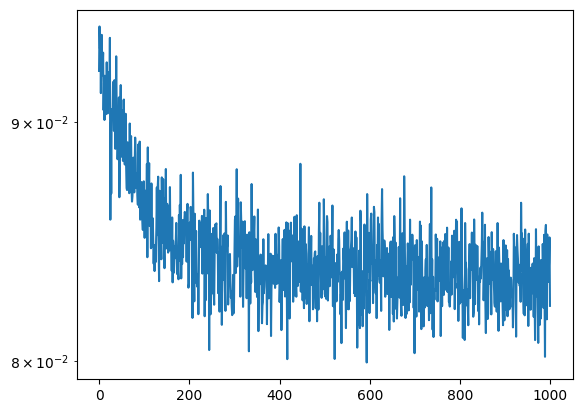

In [486]:
plt.plot(history)
plt.yscale("log")

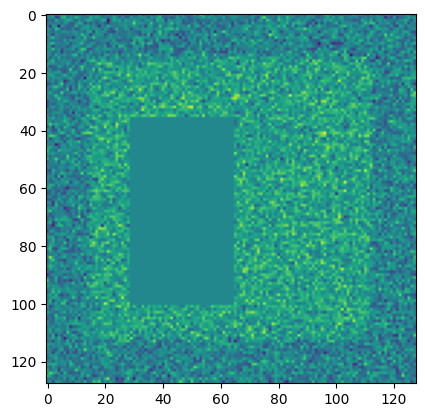

In [487]:
plt.imshow(last_frame[10].detach().cpu())

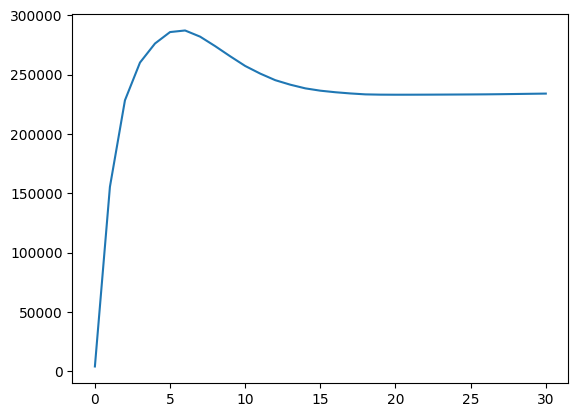

In [488]:
vs = nca_out.reshape(nca_out.shape[0], -1).sum(axis=1).detach().cpu()
plt.plot(vs)

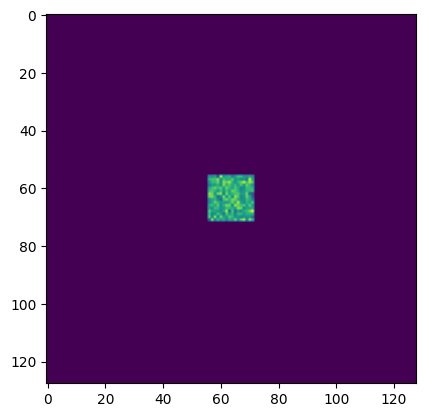

In [491]:
plt.imshow(nca_out[0, 0, 0].detach().cpu().numpy())

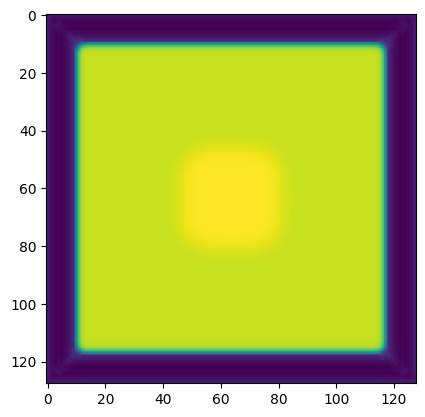

In [492]:
plt.imshow(nca_out[10, 0, 0].detach().cpu().numpy())

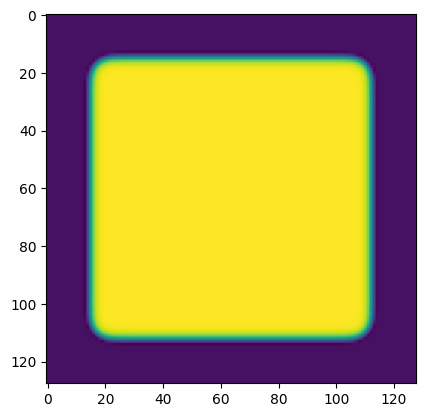

In [493]:
plt.imshow(nca_out[-1, 0, 0].detach().cpu().numpy())

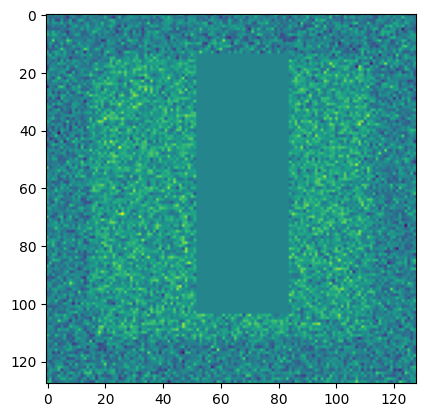

In [494]:
plt.imshow(noiser(nca_out[-1, 0, 0])[0, 0].detach().cpu())

In [458]:
# nca = nca.to("cpu")
# inv_ae = inv_ae.to("cpu")

In [459]:
# msg = inv_ae.sample_msg(bs)
# image = inv_ae.encode(msg)
# image_rep = image.repeat(1, 4, 1, 1)
# nca_out = nca.forward_many(image_rep, steps=steps)
# nca_out = torch.stack(nca_out)


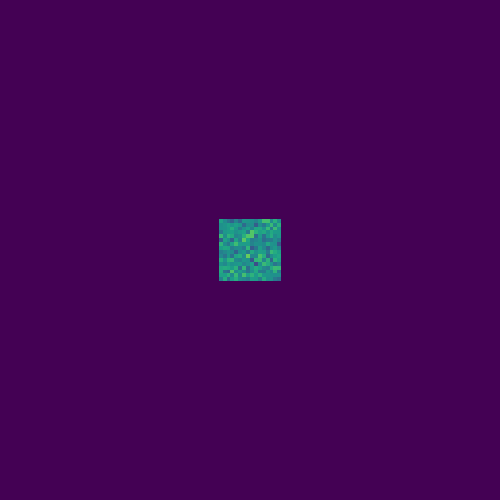

In [498]:
make_gif(nca_out[:,1,0], fps=10)